In [261]:
from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import pickle

In [262]:
train_df = pd.read_csv('../data/to2ml/train_round1.csv.gz')

In [263]:
test_df = pd.read_csv('../data/to2ml/test_round1.csv.gz')

In [266]:
test.head()

,dow,max,mean,median,min,sum
0,6,2.0,2.000000,2.0,2.0,2.0
1,0,47.0,22.457143,19.0,1.0,786.0
2,1,43.0,24.350000,24.5,1.0,974.0
3,2,52.0,28.125000,28.0,15.0,1125.0
4,3,47.0,29.868421,30.0,15.0,1135.0


In [267]:
features = list(train_df.columns.difference(['visitors']))

In [268]:
test = test_df[features]

In [269]:
test.head()

,dow,max,mean,median,min,sum
0,6,2.0,2.000000,2.0,2.0,2.0
1,0,47.0,22.457143,19.0,1.0,786.0
2,1,43.0,24.350000,24.5,1.0,974.0
3,2,52.0,28.125000,28.0,15.0,1125.0
4,3,47.0,29.868421,30.0,15.0,1135.0


In [270]:
train = train_df[features + ['visitors']]

In [271]:
train.head()

,dow,max,mean,median,min,sum,visitors
0,0,47,22.457143,19.0,1,786,20
1,0,47,22.457143,19.0,1,786,25
2,0,47,22.457143,19.0,1,786,16
3,0,47,22.457143,19.0,1,786,16
4,0,47,22.457143,19.0,1,786,27


## Ensemble Learning

- Serial application of tree based learners.
- Weak models are produced and improved over time by weighted samples
- Misclassified instances are weighed more in next iteration.
- [Tree Training Visualized](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
- [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) 
- [Gradient Boosting Playground](http://arogozhnikov.github.io/2016/07/05/gradient_boosting_playground.html)


![title](images/Picture1.png)

- **XGBoost** by DMLC
    - Supports the distributed processing frameworks Apache Hadoop, Apache Spark, and Apache Flink. 
- **LightGBM** by Microsoft
    - Faster training lower memory usage
- **CatBoost** by Yandex
    - Support for handling categorical variables
    - Process Visualisation


## XGBoost

In [169]:
train_matrix = xgb.DMatrix(train[features],label=np.log1p(train['visitors']))

/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [171]:
params = {'n_estimators':1000,
'max_depth':6,
'base_score': np.mean(np.log1p(train['visitors'])),
'learning_rate':0.02,
'n_jobs':48,
'max_delta_step':6,
'subsample':0.7,
#colsample_bylevel = 0.8,
'colsample_bytree':0.7,
#seed=666,
'reg_alpha':0.01,
'reg_lambda':2.5}

In [172]:
xgb_model = xgb.train(params,train_matrix,num_boost_round=1000)

In [173]:
def get_importance_plot(booster, figsize, **kwargs): 
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return xgb.plot_importance(booster=booster,importance_type='gain' ,ax=ax, **kwargs,max_num_features=50)

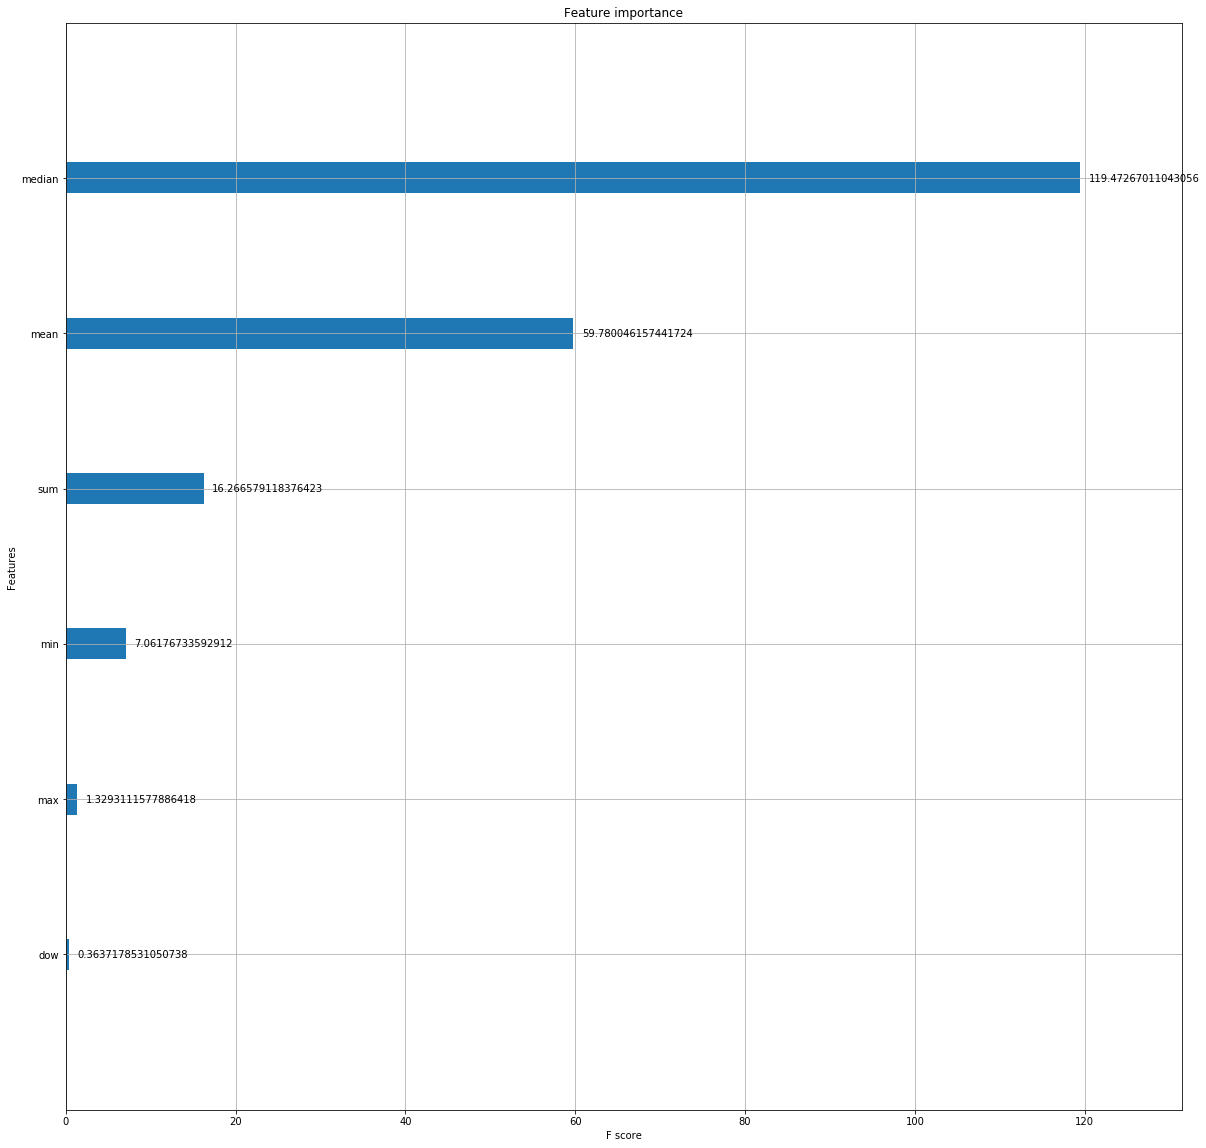

In [174]:
get_importance_plot(xgb_model,(20,20))

In [176]:
test_matrix = xgb.DMatrix(test)
xgb_test_pred = xgb_model.predict(test_matrix)

In [178]:
sub = pd.read_csv('../data/sample_submission.csv.gz')

In [192]:
sub['id'] = test_df['id']
sub['visitors'] = np.expm1(xgb_test_pred)
sub.to_csv('../data/tokaggle/xgb_reg.csv',index=False)

In [193]:
! kaggle competitions submit -c recruit-restaurant-visitor-forecasting -f ../data/tokaggle/xgb_reg.csv -m "XGB"

100%|███████████████████████████████████████| 1.27M/1.27M [00:03<00:00, 417kB/s]
Successfully submitted to Recruit Restaurant Visitor Forecasting

In [194]:
! kaggle competitions submissions -c recruit-restaurant-visitor-forecasting 

fileName               date                 description                status    publicScore  privateScore  
---------------------  -------------------  -------------------------  --------  -----------  ------------  
xgb_reg.csv            2019-11-28 14:22:30  XGB                        complete  0.52216      0.55939       
lgb_reg.csv            2019-11-23 14:44:20  DataCamp Sess2 LGBM        complete  0.71537      0.74051       
lgb_reg.csv            2019-11-23 14:33:14  DataCamp Sess2 LGBM        complete  0.71569      0.74065       
lgb_reg.csv            2019-11-23 14:25:32  DataCamp Sess2 LGBM        complete  0.71097      0.72792       
linear_reg.csv         2019-11-23 13:01:40  LinearReg session2         complete  0.57544      0.60338       
submit_mean.csv        2019-11-23 11:38:45  Mean Submissionon 2 Sessi  complete  0.88649      0.87066       
sample_submission.csv  2019-11-23 11:25:41  zero sub                   complete  2.91459      2.94249       
knn_reg.csv        

## LightGBM

In [195]:
import lightgbm as lgb

In [196]:
train_X = train[features].values
train_y = train.visitors.values

In [197]:
train_new.head()

,air_store_id,visit_date,visitors,rs1_x,rv1_x,rs2_x,rv2_x,rs1_y,rv1_y,rs2_y,rv2_y,dow,max,min,median,mean
0,air_ba937bf13d40fb24,2016-01-13,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,57,7,25.0,23.843750
1,air_ba937bf13d40fb24,2016-01-14,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,54,2,21.0,20.292308
2,air_ba937bf13d40fb24,2016-01-15,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,61,4,35.0,34.738462
3,air_ba937bf13d40fb24,2016-01-16,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,53,6,27.0,27.651515
4,air_ba937bf13d40fb24,2016-01-18,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,34,2,12.0,13.754386


In [198]:
test_X = test

In [199]:
train_matrix = lgb.Dataset(train_X,np.log1p(train_y))

In [200]:
lgb_params = {"n_jobs":-1,
            "n_estimators":1000,
            "learning_rate":0.02,
            "num_leaves":10,
            "colsample_bytree":0.7,
            "subsample":0.7,
            "max_depth":3,
            "reg_alpha":0.01,
            "reg_lambda":2.5,
            "silent":-1,
            "verbose":-1,
            "random_state":1881}

#### CV for tuning HyperParams

In [201]:
lgb.cv(lgb_params,train_matrix,stratified=False,verbose_eval=10,metrics=['rmse'],early_stopping_rounds=10)

/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/lightgbm/engine.py:502: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/lightgbm/basic.py:794: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[10]	cv_agg's rmse: 0.728959 + 0.00252664
[20]	cv_agg's rmse: 0.670048 + 0.00234284
[30]	cv_agg's rmse: 0.626237 + 0.00232945
[40]	cv_agg's rmse: 0.595115 + 0.0023658
[50]	cv_agg's rmse: 0.572849 + 0.00247314
[60]	cv_agg's rmse: 0.556966 + 0.00260513
[70]	cv_agg's rmse: 0.545896 + 0.00272183
[80]	cv_agg's rmse: 0.5382 + 0.00282459
[90]	cv_agg's rmse: 0.532866 + 0.00292569
[100]	cv_agg's rmse: 0.529148 + 0.00301293
[110]	cv_agg's rmse: 0.526553 + 0.00308861
[120]	cv_agg's rmse: 0.524726 + 0.00314289
[130]	cv_agg's rmse: 0.523449 + 0.00319026
[140]	cv_agg's rmse: 0.522555 + 0.0032325
[150]	cv_agg's rmse: 0.52191 + 0.00326264
[160]	cv_agg's rmse: 0.521444 + 0.00328611
[170]	cv_agg's rmse: 0.52112 + 0.00330363
[180]	cv_agg's rmse: 0.520882 + 0.00331597
[190]	cv_agg's rmse: 0.520712 + 0.00332678
[200]	cv_agg's rmse: 0.520588 + 0.00333714
[210]	cv_agg's rmse: 0.520498 + 0.00334456
[220]	cv_agg's rmse: 0.520433 + 0.00334799
[230]	cv_agg's rmse: 0.520385 + 0.00335456
[240]	cv_agg's rmse: 0.520

{'rmse-mean': [0.7986603689073338,
  0.7898559174906793,
  0.7813246887576406,
  0.7730420302202126,
  0.7649695077721551,
  0.7582213837708942,
  0.7505919357013582,
  0.7431514100853294,
  0.7359538799526764,
  0.7289592332091624,
  0.7221782486561263,
  0.7155681506682212,
  0.7091509899180775,
  0.7029163658232132,
  0.6968782849946287,
  0.6910129275820982,
  0.6861234653206932,
  0.6805946912940458,
  0.6752277447607681,
  0.6700476204201412,
  0.6650092718682179,
  0.6601157231352353,
  0.6553963599432419,
  0.6508077246047486,
  0.6463751136766679,
  0.6420767042047643,
  0.6379175246764507,
  0.6339002803717231,
  0.6300031090412752,
  0.6262367673300524,
  0.6225983633352101,
  0.6195470895071098,
  0.6161254413243633,
  0.6128104893916604,
  0.6096094494105604,
  0.6065124734723188,
  0.6035076163603115,
  0.6006053409646034,
  0.5978133004169328,
  0.5951152692303605,
  0.5924938454819321,
  0.5899597086457312,
  0.5875246642627243,
  0.5851652667302382,
  0.582882574870757

In [202]:
lgb_model = lgb.train(lgb_params,train_matrix,num_boost_round=320)

/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [203]:
def get_importance_plot(booster, figsize, **kwargs): 
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return lgb.plot_importance(booster=booster,importance_type='gain' ,ax=ax, **kwargs,max_num_features=50)

In [204]:
import matplotlib.pyplot as plt
%matplotlib inline

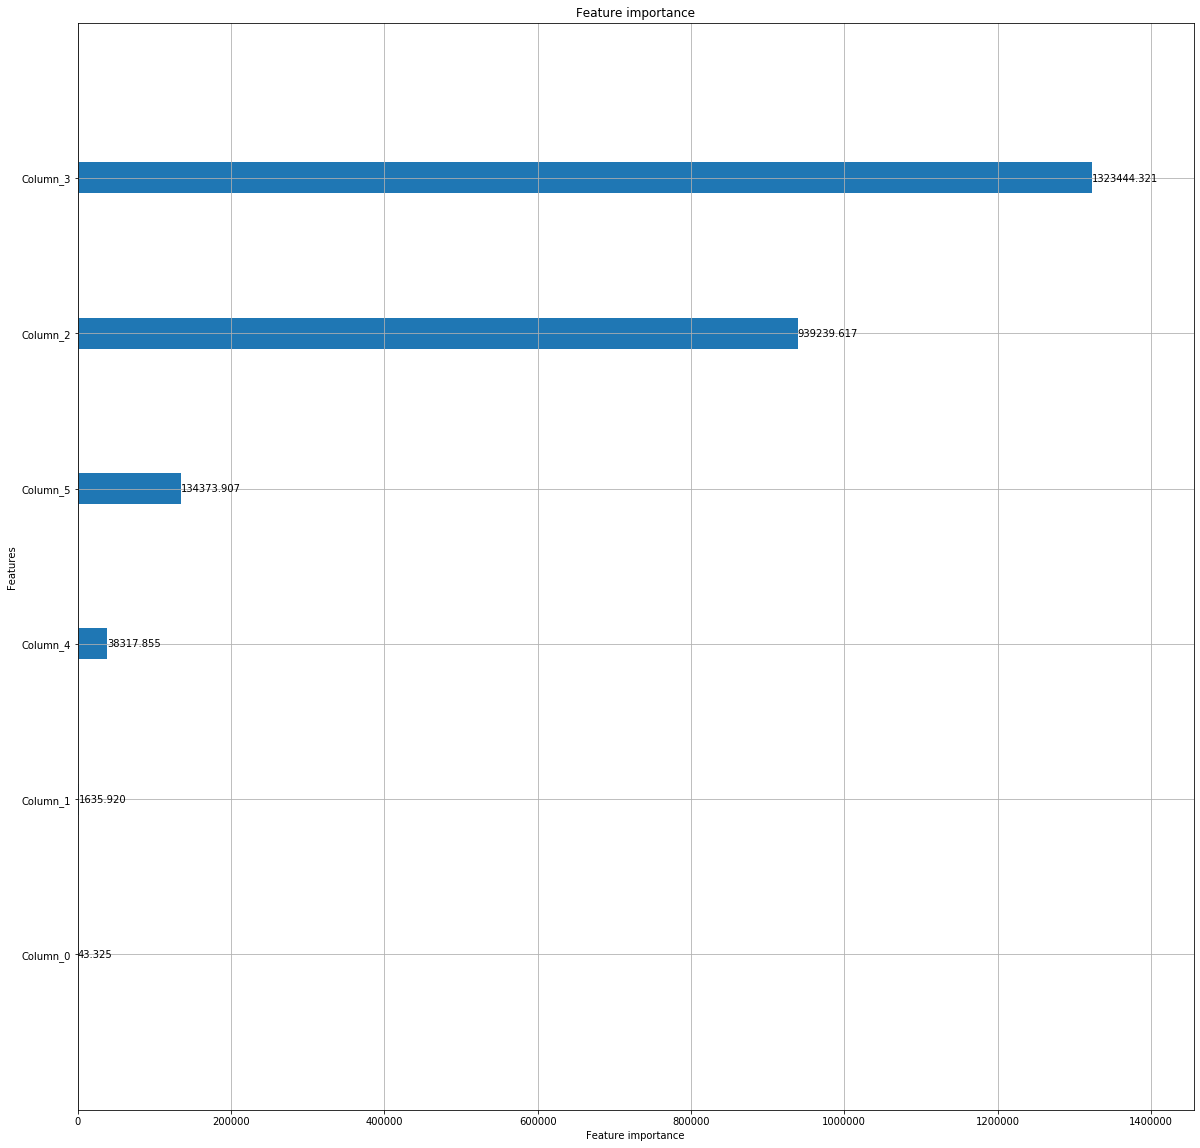

In [205]:
get_importance_plot(lgb_model,(20,20))

In [206]:
lgb_test_pred = lgb_model.predict(test_X)

In [207]:
lgb_test_pred

array([1.06609462, 2.92025521, 3.07090582, ..., 1.52099032, 1.5966754 ,
       1.59443847])

In [208]:
sub = pd.DataFrame()

In [209]:
sub['id'] = test_sub['id']
sub['visitors'] = np.expm1(lgb_test_pred)
sub.to_csv('../data/tokaggle/lgb_reg.csv',index=False)

In [72]:
test_sub = pd.read_csv('../data/sample_submission.csv.gz')

In [211]:
! kaggle competitions submit -c recruit-restaurant-visitor-forecasting -f ../data/to2ml/lgb_reg.csv -m "LGBM"

100%|███████████████████████████████████████| 1.54M/1.54M [00:06<00:00, 250kB/s]
Successfully submitted to Recruit Restaurant Visitor Forecasting

In [212]:
! kaggle competitions submissions -c recruit-restaurant-visitor-forecasting 

fileName               date                 description                status    publicScore  privateScore  
---------------------  -------------------  -------------------------  --------  -----------  ------------  
lgb_reg.csv            2019-11-28 14:27:19  LGBM                       pending   None         None          
xgb_reg.csv            2019-11-28 14:22:30  XGB                        complete  0.52216      0.55939       
lgb_reg.csv            2019-11-23 14:44:20  DataCamp Sess2 LGBM        complete  0.71537      0.74051       
lgb_reg.csv            2019-11-23 14:33:14  DataCamp Sess2 LGBM        complete  0.71569      0.74065       
lgb_reg.csv            2019-11-23 14:25:32  DataCamp Sess2 LGBM        complete  0.71097      0.72792       
linear_reg.csv         2019-11-23 13:01:40  LinearReg session2         complete  0.57544      0.60338       
submit_mean.csv        2019-11-23 11:38:45  Mean Submissionon 2 Sessi  complete  0.88649      0.87066       
sample_submission.c

## CatBoost

In [213]:
import catboost as ctb
from catboost import Pool

In [216]:
train_pool = Pool(train[features],label=np.log1p(train.visitors.values))

In [218]:
ctb_params = {'learning_rate':0.02,
              'max_depth':8,
              'l2_leaf_reg':0.5,
              'bootstrap_type':'Bernoulli', #default: bayesian
              #'bagging_temperature':1,
              #'subsample': #can be set when bootstrap type is not default
              'thread_count':48,
              'loss_function':'RMSE'    
             }

In [219]:
ctb_model = ctb.train(pool=train_pool,params=ctb_params,num_boost_round=1000,verbose=1)

0:	learn: 2.8608330	total: 94.8ms	remaining: 1m 34s
1:	learn: 2.8057895	total: 143ms	remaining: 1m 11s
2:	learn: 2.7518615	total: 191ms	remaining: 1m 3s
3:	learn: 2.6991362	total: 238ms	remaining: 59.2s
4:	learn: 2.6474256	total: 283ms	remaining: 56.3s
5:	learn: 2.5968134	total: 328ms	remaining: 54.3s
6:	learn: 2.5472305	total: 371ms	remaining: 52.6s
7:	learn: 2.4986456	total: 409ms	remaining: 50.7s
8:	learn: 2.4510318	total: 451ms	remaining: 49.6s
9:	learn: 2.4045663	total: 494ms	remaining: 48.9s
10:	learn: 2.3589553	total: 538ms	remaining: 48.4s
11:	learn: 2.3143490	total: 579ms	remaining: 47.7s
12:	learn: 2.2706007	total: 621ms	remaining: 47.1s
13:	learn: 2.2277592	total: 662ms	remaining: 46.6s
14:	learn: 2.1858358	total: 706ms	remaining: 46.4s
15:	learn: 2.1448575	total: 746ms	remaining: 45.9s
16:	learn: 2.1047895	total: 791ms	remaining: 45.8s
17:	learn: 2.0654751	total: 837ms	remaining: 45.7s
18:	learn: 2.0270107	total: 882ms	remaining: 45.5s
19:	learn: 1.9893315	total: 928ms	rema

### Bayesian Optimization 

![title](images/bopt.png)

In [220]:
from bayes_opt import BayesianOptimization
import xgboost as xgb

In [223]:
def prepare_xgb_data():
    df = train
    label = train_df.visitors
    return df,label

In [224]:
def save_obj(obj, name ):
    with open('optim_results/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma,
                 reg_alpha,
                 reg_lambda,
                 max_delta_step):

    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    params['reg_alpha'] = max(reg_alpha, 0)
    params['reg_lamda'] = max(reg_lambda, 0)
    params['max_delta_step'] = int(max_delta_step)

    
    folds = KFold(n_splits= 3, shuffle=True, random_state=1881)
    oof_preds = np.zeros(train_df.shape[0])
    feats = train_df.columns
    rmse_scores = np.zeros(folds.n_splits)

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], labels)):
        train_x, train_y = train_df[feats].iloc[train_idx], labels.iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], labels.iloc[valid_idx]

        clf = xgb.XGBRegressor(**params)
        
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'rmse',verbose= 0,early_stopping_rounds= 3)
        
        
        rmse_scores[n_fold]=mean_squared_error(valid_y,clf.predict(valid_x, ntree_limit=clf.best_iteration))

        del clf, train_x, train_y, valid_x, valid_y

    return -np.log1p(np.sqrt(np.mean(rmse_scores)))

In [229]:
if __name__ == '__main__':
    train_df,labels = prepare_xgb_data()
    base_mean = np.mean(labels)

    num_rounds = 1000
    random_state = 666
    num_iter = 5
    init_points = 3
    params = {
        'n_estimators':num_rounds,
        'learning_rate': 0.05,
        'silent': 1,
        'eval_metric': 'rmse',
        'verbose_eval': False,
        'seed': random_state,
        'n_jobs':-1,
        'base_score':base_mean
    }

    xgbBO = BayesianOptimization(xgb_evaluate, {'min_child_weight': (1, 20),
                                                'colsample_bytree': (0.5, 1),
                                                'max_depth': (2, 8),
                                                'subsample': (0.5, 1),
                                                'gamma': (0, 10),
                                                'reg_alpha': (0, 5),
                                                'reg_lambda': (0, 5),
                                                'max_delta_step':(2,15)
                                                })

    xgbBO.maximize(init_points=init_points, n_iter=num_iter)
    
    save_obj(xgbBO.res,'xgb_bopt_results')
    print("Search Resuls Saved!")

|   iter    |  target   | colsam... |   gamma   | max_de... | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------


/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


|  1        | -1.131    |  0.8678   |  7.023    |  12.7     |  5.666    |  8.764    |  3.134    |  2.984    |  0.5098   |


/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


|  2        | -1.519    |  0.7083   |  5.242    |  2.218    |  6.428    |  11.14    |  4.243    |  4.796    |  0.573    |


/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


|  3        | -1.482    |  0.7192   |  1.685    |  2.643    |  6.331    |  1.07     |  4.491    |  4.797    |  0.5465   |


/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


|  4        | -1.232    |  0.5      |  0.0      |  15.0     |  2.0      |  20.0     |  0.0      |  0.0      |  1.0      |


/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


|  5        | -1.212    |  0.5      |  10.0     |  15.0     |  2.0      |  1.0      |  0.0      |  0.0      |  1.0      |


/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


|  6        | -1.159    |  1.0      |  10.0     |  15.0     |  8.0      |  20.0     |  5.0      |  0.0      |  0.5      |


/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


|  7        | -0.4493   |  1.0      |  0.0      |  15.0     |  8.0      |  1.0      |  0.0      |  5.0      |  0.5      |


/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


|  8        | -0.3017   |  1.0      |  0.0      |  15.0     |  8.0      |  1.0      |  5.0      |  0.0      |  1.0      |
Search Resuls Saved!


In [230]:
with open('optim_results/xgb_bopt_results.pkl','rb') as f:
    res = pickle.load(f)
f.close()

In [234]:
result_scores = [res_dict['target'] for res_dict in res]

In [241]:
best_dict = res[np.argsort(result_scores)[-1]]

In [243]:
optimized_params = best_dict['params']

In [245]:
optimized_params['max_depth'] = int(optimized_params['max_depth'])
optimized_params['min_child_weight'] = int(optimized_params['min_child_weight'])
optimized_params['max_delta_step'] = int(optimized_params['max_delta_step'])

In [247]:
fixed_params = {
        'n_estimators':num_rounds,
        'learning_rate': 0.05,
        'silent': 1,
        'eval_metric': 'rmse',
        'verbose_eval': False,
        'seed': random_state,
        'n_jobs':-1,
        'base_score':base_mean
    }

In [248]:
params = {**optimized_params,**fixed_params}

In [249]:
clf = xgb.XGBRegressor(**params)

In [251]:
train_matrix = xgb.DMatrix(train[features],label=np.log1p(train['visitors']))

/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [252]:
xgb_model = xgb.train(params,train_matrix,num_boost_round=1000)

In [253]:
xgb_test_pred = xgb_model.predict(test_matrix)

In [255]:
sub['id'] = test_sub['id']
sub['visitors'] = np.expm1(xgb_test_pred)
sub.to_csv('../data/tokaggle/optimized_xgb_reg.csv',index=False)

In [256]:
! kaggle competitions submit -c recruit-restaurant-visitor-forecasting -f ../data/to2ml/optimized_xgb_reg.csv -m "Optimized XGB"

100%|███████████████████████████████████████| 1.27M/1.27M [00:05<00:00, 247kB/s]
Successfully submitted to Recruit Restaurant Visitor Forecasting

In [258]:
! kaggle competitions submissions -c recruit-restaurant-visitor-forecasting 

fileName               date                 description                status    publicScore  privateScore  
---------------------  -------------------  -------------------------  --------  -----------  ------------  
optimized_xgb_reg.csv  2019-11-28 15:26:14  Optimized XGB              complete  0.52154      0.55867       
lgb_reg.csv            2019-11-28 14:27:19  LGBM                       complete  0.52335      0.56034       
xgb_reg.csv            2019-11-28 14:22:30  XGB                        complete  0.52216      0.55939       
lgb_reg.csv            2019-11-23 14:44:20  DataCamp Sess2 LGBM        complete  0.71537      0.74051       
lgb_reg.csv            2019-11-23 14:33:14  DataCamp Sess2 LGBM        complete  0.71569      0.74065       
lgb_reg.csv            2019-11-23 14:25:32  DataCamp Sess2 LGBM        complete  0.71097      0.72792       
linear_reg.csv         2019-11-23 13:01:40  LinearReg session2         complete  0.57544      0.60338       
submit_mean.csv    